In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

import plotnine as p9

import liana as li
import decoupler as dc
import omnipath as op
import matplotlib
import os

In [2]:
from matplotlib import rcParams

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['Arial']
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import seaborn as sns
sns.set_theme(style="ticks", rc=custom_params)
import importlib
importlib.reload(li)
# verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.verbosity = 3
sc.logging.print_header()
mycmap = matplotlib.colors.LinearSegmentedColormap.from_list('mycmap', ["#004369", "white", "#DB1F48"])
sc.set_figure_params(dpi=900, color_map="bwr")
%matplotlib inline


2024-06-13 14:37:47.395640: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


scanpy==1.10.0 anndata==0.8.0 umap==0.5.5 numpy==1.26.3 scipy==1.11.4 pandas==1.5.3 scikit-learn==1.4.0 statsmodels==0.14.0 igraph==0.10.3 pynndescent==0.5.8


In [3]:
os.chdir('/mnt/data/hong/2022/human_placenta/')
adata = sc.read_h5ad('output/10x_h5/h5ad/ad_v2.h5ad')

In [4]:
naga = adata[adata.obs['group']=='Normal_AGA']

In [5]:
naga.X = naga.layers['log_norm'].copy()

In [6]:
dea_df = pd.read_csv('output/communication/all_de_ccc_input.tsv', sep='\t')

In [13]:
dea_df_lr = dea_df[~dea_df['final_celltypes'].isin(['B cells', 'EVT', 'eSTB', 'pCTB', 'Endo-2', 'Myofibroblast', 'T cells', 'NK cells', 'B cells', 'Monocyte'])]

In [14]:
dea_df_lr = dea_df_lr.set_index('Unnamed: 0')

In [15]:
set(dea_df_lr.final_celltypes) & set(naga.obs.final_celltypes)

{'CTB', 'Endo-1', 'Fibroblast', 'Hofbauer cells', 'STB-a', 'STB-b', 'STB-c'}

In [16]:
naga.obs.final_celltypes.value_counts()

STB-c             5816
STB-b             3183
CTB               1288
Fibroblast         848
Endo-1             802
STB-a              727
Hofbauer cells     503
Myofibroblast      287
pCTB               255
Endo-2             163
eSTB               121
EVT                 86
NK cells            82
Monocyte            48
B cells             17
T cells             12
Name: final_celltypes, dtype: int64

In [20]:
lr_res.source.value_counts()

STB-c            273
CTB              258
Fibroblast       224
STB-b            200
Endo-1           174
STB-a            102
Myofibroblast     91
pCTB              69
Endo-2            27
Name: source, dtype: int64

In [16]:
lr_res = li.multi.df_to_lr(naga,
                           dea_df=dea_df_lr,
                           resource_name='consensus',
                           expr_prop=0, # calculated for adata as passed - used to filter interactions
                           groupby='final_celltypes',
                           stat_keys=['score', 'p'],
                           use_raw=False,
                           complex_col='score', 
                           verbose=True,
                           return_all_lrs=False,
                           )

Using resource `consensus`.
Using `.X`!
1307 features of mat are empty, they will be removed.
/mnt/data/hong/anaconda3/envs/scanpy/lib/python3.10/site-packages/liana/method/_pipe_utils/_pre.py:148: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
0.81 of entities in the resource are missing from the data.


In [17]:
lr_res = lr_res.sort_values("interaction_score", ascending=False, key=abs)
lr_res.head()

,ligand,ligand_complex,receptor_complex,source,ligand_score,ligand_p,ligand_expr,ligand_props,receptor,target,receptor_score,receptor_p,receptor_expr,receptor_props,interaction_score,interaction_p,interaction_expr,interaction_props,interaction
471,VEGFC,VEGFC,FLT1,Endo-1,0.1118,0.3116,0.366118,0.440150,FLT1,STB-c,1.8781,0.0004,0.494658,0.400963,0.99495,0.15600,0.430388,0.420556,VEGFC^FLT1
271,PGF,PGF,FLT1_KDR,CTB,0.0553,0.2177,0.116765,0.186335,FLT1,STB-c,1.8781,0.0004,0.494658,0.400963,0.96670,0.10905,0.305712,0.293649,PGF^FLT1_KDR
1162,PGF,PGF,FLT1_KDR,STB-b,-0.0340,0.1118,0.445597,0.421615,FLT1,STB-c,1.8781,0.0004,0.494658,0.400963,0.92205,0.05610,0.470127,0.411289,PGF^FLT1_KDR
1462,PGF,PGF,FLT1_KDR,STB-c,-0.1418,0.0066,0.654833,0.624140,FLT1,STB-c,1.8781,0.0004,0.494658,0.400963,0.86815,0.00350,0.574746,0.512552,PGF^FLT1_KDR
1300,CALM1,CALM1,RYR2,STB-c,0.4625,0.0130,0.294220,0.377923,RYR2,Fibroblast,1.2572,0.0074,0.719552,0.603774,0.85985,0.01020,0.506886,0.490848,CALM1^RYR2


In [18]:
lr_res.to_csv('output/communication/all_de_intravillous_lr_major.tsv', sep='\t')

In [26]:
# evt_stbs = ['EVT', 'STB-a', "STB-b", "STB-c"]
lr_res_evt_stbs = lr_res[(lr_res['source'].isin(evt_stbs))&(lr_res['target'].isin(evt_stbs))]

In [30]:
# lr_res_evt_stbs = lr_res_evt_stbs.sort_values("interaction_score", ascending=False, key=abs)
lr_res_evt_stbs_sig = lr_res_evt_stbs[lr_res_evt_stbs['interaction_p']<0.05]

In [37]:
lr_res_evt_stbs_sig = lr_res_evt_stbs_sig.reset_index()

In [38]:
li.pl.tileplot(liana_res=lr_res_evt_stbs_sig,
               adata = None,
               fill = 'score',
               label='p',
               label_fun = lambda x: '*' if x < 0.05 else np.nan,
               top_n=15,
               orderby = 'interaction_score',
               orderby_ascending = False,
               orderby_absolute = False,
               source_lables = 'source',
               target_lables=''
               source_title='Ligand',
               target_title='Receptor',
               )

/mnt/data/hong/anaconda3/envs/scanpy/lib/python3.10/site-packages/liana/plotting/_common.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


InvalidIndexError: Reindexing only valid with uniquely valued Index objects

In [70]:
lr_res_evt_stbs_sig['combined'] = lr_res_evt_stbs_sig['interaction'] + lr_res_evt_stbs_sig['source'] + lr_res_evt_stbs_sig['target']
lr_res_evt_stbs_sig_filter = lr_res_evt_stbs_sig[lr_res_evt_stbs_sig['receptor_complex']=='ITGB1']
df_ligand = lr_res_evt_stbs_sig_filter.pivot(index='combined', columns='source', values='ligand_score')
df_receptor = lr_res_evt_stbs_sig_filter.pivot(index='combined', columns='target', values='receptor_score')

In [71]:
selected_bool = (df_receptor['EVT'].notna()) & (df_receptor['EVT'].notna())
df_ligand_selected = df_ligand[selected_bool]
df_receptor_selected = df_receptor[selected_bool]

In [73]:
lr_res_evt_stbs_sig_filter

,index,ligand,receptor,ligand_complex,receptor_complex,source,ligand_score,ligand_p,ligand_expr,ligand_props,...,receptor_score,receptor_p,receptor_expr,receptor_props,interaction_score,interaction_p,interaction_expr,interaction_props,interaction,combined
2,1232,FBLN1,ITGB1,FBLN1,ITGB1,STB-c,0.5733,0.0071,1.709569,0.926410,...,2.7045,0.0175,0.758659,0.755814,1.63890,0.01230,1.234114,0.841112,FBLN1^ITGB1,FBLN1^ITGB1STB-cEVT
3,998,FBLN1,ITGB1,FBLN1,ITGB1,STB-b,0.4624,0.0060,1.305272,0.796733,...,2.7045,0.0175,0.758659,0.755814,1.58345,0.01175,1.031965,0.776273,FBLN1^ITGB1,FBLN1^ITGB1STB-bEVT
4,858,FBLN1,ITGB1,FBLN1,ITGB1,STB-a,0.3781,0.0217,1.362875,0.855571,...,2.7045,0.0175,0.758659,0.755814,1.54130,0.01960,1.060767,0.805692,FBLN1^ITGB1,FBLN1^ITGB1STB-aEVT
8,999,TIMP2,ITGB1,TIMP2,ITGB1,STB-b,0.2477,0.0340,0.654341,0.573358,...,2.7045,0.0175,0.758659,0.755814,1.47610,0.02575,0.706500,0.664586,TIMP2^ITGB1,TIMP2^ITGB1STB-bEVT
12,1233,TIMP2,ITGB1,TIMP2,ITGB1,STB-c,0.1616,0.0573,0.762255,0.709422,...,2.7045,0.0175,0.758659,0.755814,1.43305,0.03740,0.760457,0.732618,TIMP2^ITGB1,TIMP2^ITGB1STB-cEVT
13,1227,HSPG2,ITGB1,HSPG2,ITGB1,STB-c,-0.0243,0.0639,0.236207,0.305021,...,2.7045,0.0175,0.758659,0.755814,1.34010,0.04070,0.497433,0.530417,HSPG2^ITGB1,HSPG2^ITGB1STB-cEVT
14,997,TGFB1,ITGB1,TGFB1,ITGB1,STB-b,-0.0912,0.0393,0.145660,0.153943,...,2.7045,0.0175,0.758659,0.755814,1.30665,0.02840,0.452159,0.454878,TGFB1^ITGB1,TGFB1^ITGB1STB-bEVT
15,992,ADAM12,ITGB1,ADAM12,ITGB1,STB-b,-0.1631,0.0171,3.780977,0.966070,...,2.7045,0.0175,0.758659,0.755814,1.27070,0.01730,2.269818,0.860942,ADAM12^ITGB1,ADAM12^ITGB1STB-bEVT


/mnt/data/hong/anaconda3/envs/scanpy/lib/python3.10/site-packages/seaborn/utils.py:80: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
/tmp/ipykernel_4172473/2984964852.py:6: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
maxp pruned
LTSH dropped
cmap pruned
kern pruned
post pruned
PCLT dropped
JSTF dropped
DSIG dropped
GSUB pruned
glyf pruned
Added gid0 to subset
Added first four glyphs to subset
Closing glyph list over 'GSUB': 41 glyphs before
Glyph names: ['.notdef', '.null', 'A', 'B', 'D', 'E', 'F', 'G', 'H', 'I', 'L', 'M', 'N', 'P', 'S', 'T', 'V', 'a', 'asciicircum', 'b', 'c', 'd', 'e', 'eight', 'g', 'hyphen', 'i', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'period', 'r', 's', 'space', 't', 'three', 'two', 'u', 'zero']
Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 20, 21, 22, 27, 36, 37, 39, 40, 41, 42, 43, 44, 47

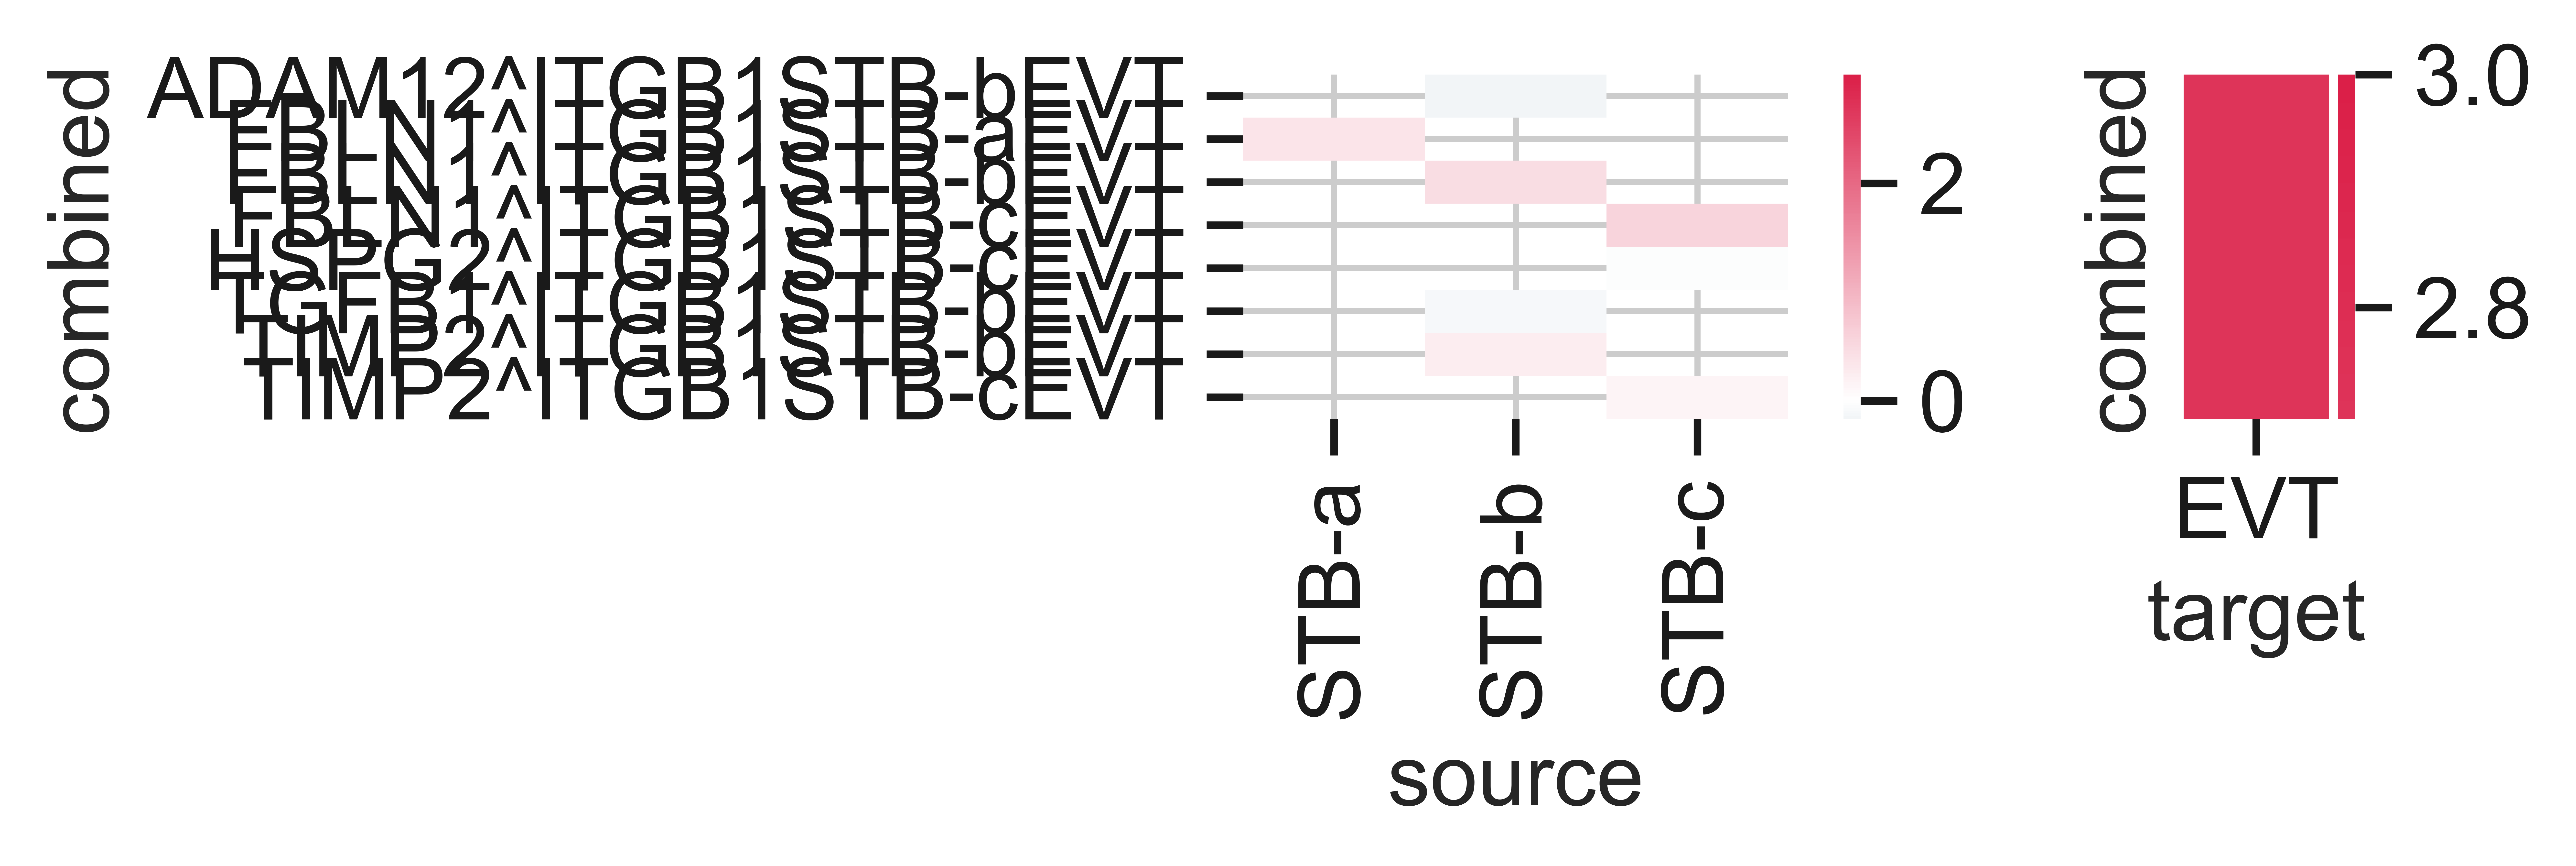

In [72]:
from matplotlib.colors import LinearSegmentedColormap
my_cmap = LinearSegmentedColormap.from_list('mycmap', ["#004369", "white", "#DB1F48"])
fig, axs = plt.subplots(1, 2, layout="constrained", figsize=(3, 3),  width_ratios=[3, 1])
sns.heatmap(df_ligand_selected, annot=False, cmap=my_cmap, cbar=True, fmt=".2f", annot_kws={"size": 10}, xticklabels=True, yticklabels=True, center=0, vmax=3, ax=axs[0])
sns.heatmap(df_receptor_selected[['EVT']], annot=False, cmap=my_cmap, cbar=True, fmt=".2f", annot_kws={"size": 10}, xticklabels=True, yticklabels=False, center=0, vmax=3,ax=axs[1])
plt.savefig('figures/ccc/evt_stbs_selected_filter.pdf')
